In [15]:
import numpy as np
import pandas as pd
from sklearn import linear_model, ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from wordcloud import STOPWORDS
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
import lightgbm as lgb

In [16]:
# Read preprocessed data
df_train = pd.read_csv("C:/Users/Philip/PythonProjects/KaggleNLP_SOA/data_train_user_clean.csv")
df_test = pd.read_csv("C:/Users/Philip/PythonProjects/KaggleNLP_SOA/data_test_user_clean.csv")

In [17]:
# Drop useless columns / columns that didn't end up being important
df_train.drop(columns=['tweet_id', 'screen_name', 'created_at', 'join_date', 'hour', 'in_reply_to_screen_name',
                        'urls', 'hashtags', 'user_mentions', 'location', 'user_description', 'full_text','text_clean','month', 'day'], inplace=True)
df_test.drop(columns=['tweet_id', 'screen_name', 'created_at', 'join_date', 'hour', 'in_reply_to_screen_name', 
                        'urls', 'hashtags', 'user_mentions', 'location', 'user_description', 'full_text','text_clean','month', 'day'],  inplace=True)

In [15]:
# After speaking with winner of competition, removing the very large outliers
# ended up massively improving score. I did not do this initially, but this line of code
# would've put my submission in 1st place!

# df_train = df_train.drop(df_train.nlargest(20, 'engagement_count').index)

In [18]:
# Target variable

X = df_train.drop(columns=['engagement_count'], inplace=False)
y = df_train['engagement_count']


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [19]:
# Base parameters for a few of the models I tried

paramsRF = {
    "n_estimators": 500,
    "max_features": 'sqrt',
    "max_depth": 5,
}
paramsGB = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 100,
    "max_features": 'sqrt',
    "learning_rate": 0.001,
    "loss": "squared_error",
}
paramsXGB = {
    "n_estimators" : 1000,
    "max_depth" : 9,
    "gamma" : 0.1,
    "learning_rate" : 0.01,
}
paramsLGB = {
    "n_estimators": 100,
    "learning_rate" : 0.01
}

In [20]:
model_baseRF = RandomForestRegressor(**paramsRF)
model_baseGB = ensemble.GradientBoostingRegressor(**paramsGB)
model_baseXGB = xgb.XGBRegressor(objective ='reg:squarederror', **paramsXGB)
model_baseLGB = lgb.LGBMRegressor(**paramsLGB)


In [218]:
#model_baseRF.fit(X_train, y_train)
#model_baseGB.fit(X_train, y_train)
model_baseXGB.fit(X_train, y_train)
model_baseLGB.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.01)

In [7]:
# Hyper-parameters tuning by CV, could be improved but was limited due to time constraints of competition

paramsRF_grid = {
    "n_estimators": [100, 200, 500,1000],
    "max_features": ['sqrt'],
    "max_depth": [5,10,20],
    "min_samples_split": [5, 10, 50],
    "min_samples_leaf": [1, 2, 4,8],
}
paramsGB_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5,10,20],
    "min_samples_split": [100],
    "max_features": ['sqrt'],
    "learning_rate": [0.001, 0.01, 0.1,1],
    "loss": ["squared_error"],
}
paramsXGB_grid = {
    "n_estimators" : [100, 200, 500],
    "max_depth" : [5,10,20],
    "gamma" : [0,0.01, 0.1],
    "learning_rate" : [0.001, 0.01, 0.1,1],
}
paramsLGB_grid = {
    "n_estimators": [100,200],
    "max_depth": [5,10,20],
    "learning_rate" : [0.001, 0.01, 0.1],
    "feature_fraction" : [0.5, 0.8],
    "bagging_fraction" : [0.5, 0.8],
    "bagging_freq" : [5, 10]
}

In [8]:
model_tuneRF = RandomForestRegressor(random_state = 2021)
model_tuneGB = ensemble.GradientBoostingRegressor(random_state = 2021)
model_tuneXGB = xgb.XGBRegressor(objective ='reg:squarederror', random_state = 2021)
model_tuneLGB = lgb.LGBMRegressor(random_state = 2021)

In [206]:
# Hyper-parameter tuning by grid-search

GS_RF = GridSearchCV(estimator = model_tuneRF,
                  param_grid = paramsRF_grid,
                  scoring = ["neg_root_mean_squared_error"],
                  refit = "neg_root_mean_squared_error",
                  cv = 10,
                  verbose = 4)

GS_GB = GridSearchCV(estimator = model_tuneGB,
                  param_grid = paramsGB_grid,
                  scoring = ["neg_root_mean_squared_error"],
                  refit = "neg_root_mean_squared_error",
                  cv = 10,
                  verbose = 4)

GS_XGB = GridSearchCV(estimator = model_tuneXGB,
                  param_grid = paramsXGB_grid,
                  scoring = ["neg_root_mean_squared_error"],
                  refit = "neg_root_mean_squared_error",
                  cv = 10,
                  verbose = 4)
     
GS_LGB = GridSearchCV(estimator = model_tuneLGB,
                  param_grid = paramsLGB_grid,
                  scoring = ["neg_root_mean_squared_error"],
                  refit = "neg_root_mean_squared_error",
                  cv = 10,
                  verbose = 4)

#GS_RF.fit(X_train, y_train)   
#GS_GB.fit(X_train, y_train)
GS_XGB.fit(X_train, y_train)
GS_LGB.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LGBMRegressor(random_state=2021),
             param_grid={'bagging_fraction': [0.5, 0.8],
                         'bagging_freq': [5, 10],
                         'feature_fraction': [0.5, 0.8],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [5, 10, 20], 'n_estimators': [100, 200]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error'], verbose=4)

In [218]:
print(GS_XGB.best_params_)
print(GS_RF.best_params_)
print(GS_GB.best_params_)
print(GS_LGB.best_params_)

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
{'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 100, 'n_estimators': 500}
{'bagging_fraction': 0.8, 'bagging_freq': 5, 'feature_fraction': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}


In [219]:
print(GS_XGB.best_score_)
print(GS_RF.best_score_)
print(GS_GB.best_score_)
print(GS_LGB.best_score_)

-768.2251129826689
-696.249595634873
-689.3296491064438
-696.0876043920928


In [21]:
# Parameters used for final models

paramsRF_real = {
    "n_estimators": 1000,
    "max_features": 'sqrt',
    "max_depth": 20,
    "min_samples_split": 5,
    "min_samples_leaf": 1
}
paramsGB_real = {
    "n_estimators": 500,
    "max_depth": 20,
    "min_samples_split": 100,
    "max_features": 'sqrt',
    "learning_rate": 0.01,
    "loss": "squared_error",
}
paramsXGB_real = {
    "n_estimators" : 1000,
    "max_depth" : 8,
    "gamma" : 1,
    "learning_rate" : 0.01,
}
paramsLGB_real = {
    "n_estimators": 1000,
    "max_depth": 20,
    "learning_rate" : 0.01,
    "feature_fraction" : 0.8,
    "bagging_fraction" : 0.8,
    "bagging_freq" : 5,
}

In [22]:
# Only ended up using XGB and LGB ensemble model

#model_realRF = RandomForestRegressor(**paramsRF_real)
#model_realGB = ensemble.GradientBoostingRegressor(**paramsGB_real)
model_realXGB = xgb.XGBRegressor(objective ='reg:squarederror', **paramsXGB_real)
model_realLGB = lgb.LGBMRegressor(objective ='regression',**paramsLGB_real)
#print("rf")
#model_realRF.fit(X_train, y_train)
#print("gb")
#model_realGB.fit(X_train, y_train)
print("xgb")
model_realXGB.fit(X_train, y_train)
print("lgb")
model_realLGB.fit(X_train, y_train)

xgb
lgb
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
              learning_rate=0.01, max_depth=20, n_estimators=1000,
              objective='regression')

In [23]:
# Ensemble stacking of XGB and LGB models

estimators = [
    ('XGB', model_realXGB),
    ('LGB', model_realLGB)
]
model = ensemble.StackingRegressor(estimators=estimators, final_estimator=linear_model.LinearRegression(), cv=5)
model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

StackingRegressor(cv=5,
                  estimators=[('XGB',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=1,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('LGB',
                               LGBMRegressor(bagging_fraction=0.8,
                                             bagging_freq=5,
                                             feature_fraction=0.8,
                                             learning_rate=0.01, max_depth=20,
                                             n_estimators=1000,
                                             objective='regression'))],
                  final_estimator=LinearRegression())

In [24]:
#rmse = np.sqrt(mean_squared_error((y_test), (model_baseLGB.predict(X_test))))
#print("The root mean squared error (RMSE) on test set of the base LGB: {:.4f}".format(rmse))
#rmse = np.sqrt(mean_squared_error(y_test, model_baseXGB.predict(X_test)))
#print("The root mean squared error (RMSE) on test set of the base XG: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_test, model_realLGB.predict(X_test)))
print("The root mean squared error (RMSE) on test set of the LGBM: {:.4f}".format(rmse))
rmse = np.sqrt(mean_squared_error(y_test, model_realXGB.predict(X_test)))
print("The root mean squared error (RMSE) on test set of the XGBoost: {:.4f}".format(rmse))
#rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
#print("The root mean squared error (RMSE) on test set of the stacked model: {:.4f}".format(rmse))

The root mean squared error (RMSE) on test set of the LGBM: 1037.0509
The root mean squared error (RMSE) on test set of the XGBoost: 1112.9836


In [25]:
# Stacking model gives improvement

rmse = np.sqrt(mean_squared_error((y_test), (model.predict(X_test))))
print("The root mean squared error (RMSE) on test set of the RF: {:.4f}".format(rmse))

The root mean squared error (RMSE) on test set of the RF: 1033.4225


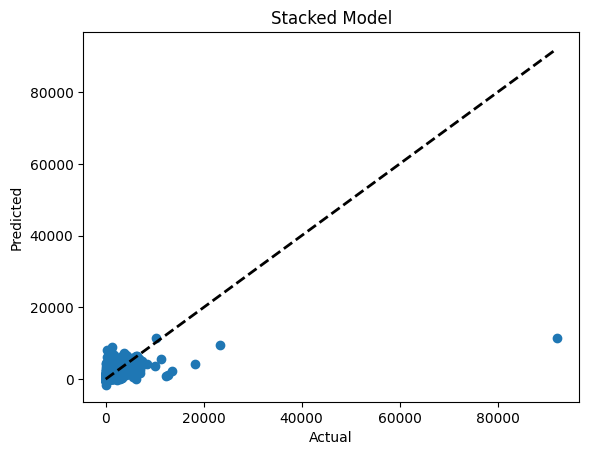

In [26]:
# Scatter plot of my final model that resulted in 6th place, definitely place for improvement

plt.scatter(y_test, model.predict(X_test))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Stacked Model')
plt.show()


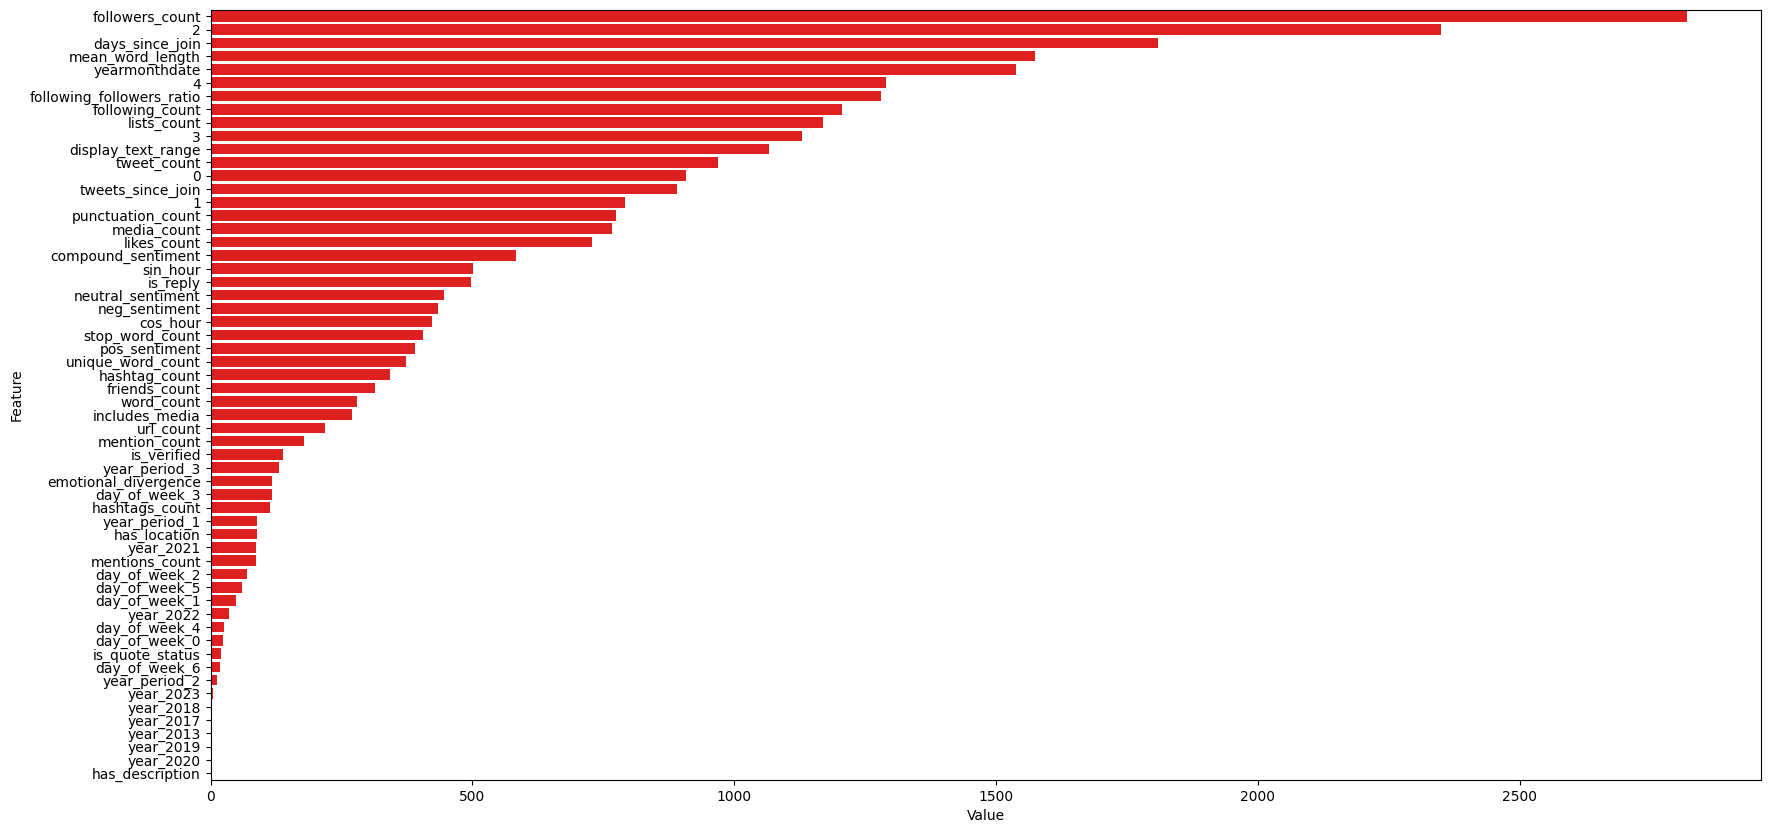

In [29]:
# Feature importance of the LGB model, a lot of features could have been removed / modified
# 0, 1, 2, 3, 4 features are from LDA topic extraction 

feature_imp = pd.DataFrame(sorted(zip(model_realLGB.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:100], color='red');

In [30]:
# Submission file

sample_submission = pd.read_csv("C:/Users\Philip/PythonProjects/KaggleNLP_SOA/expert_samplesubmission.csv")
sample_submission["engagement_count"] = model_realXGB.predict(df_test) 
sample_submission.to_csv("C:/Users\Philip/PythonProjects/KaggleNLP_SOA/submission.csv", index=False)